In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import triton

from pytorch_baseline import sinkhorn_pytorch
from triton_kernels import (
    sinkhorn_fused_A_in_global_memory,
    sinkhorn_fused_A_in_registers,
    sinkhorn_unfused,
)


def get_sinkhorn_flops(B: int, N: int, n_iter: int) -> int:
    ops_per_normalization = (
        2 * N**2 + N
    )  # row/col normalization ops: N^2 (mult) + N^2 (add) + N (div)
    ops_per_iter = 2 * ops_per_normalization
    ops_final = 2 * N**2  # multiply A by row/col normalizer (N^2 each)
    ops_per_matrix = ops_per_iter * n_iter + ops_final
    return B * ops_per_matrix


def get_sinkhorn_bytes(B: int, N: int, elem_size: int) -> int:
    # NOTE: valid only for sinkhorn_fused_A_in_registers kernel
    elem_read_matrix = 4 * N**2  # global memory -> registers
    elem_write_matrix = 4 * N**2  # registers -> global memory
    bytes_per_matrix = (elem_read_matrix + elem_write_matrix) * elem_size
    return B * bytes_per_matrix


# Define the grid
B_list = [1, 16, 64, 256, 1024, 4096]
N_list = [4, 8, 16, 32, 64, 128]
# Keep N<=128 for sinkhorn_fused_A_in_registers kernel safety
# -> 128*128*4=64KB fits in Registers, but 256*256*4=256KB does not
# -> N=256 would lead to spill over in local memory (VRAM), significantly slowing down the kernel
n_iter = 20
epsilon = 1e-6
providers = {
    "sinkhorn_pytorch": sinkhorn_pytorch,
    "sinkhorn_unfused": sinkhorn_unfused,
    "sinkhorn_fused_A_in_global_memory": sinkhorn_fused_A_in_global_memory,
    "sinkhorn_fused_A_in_registers": sinkhorn_fused_A_in_registers,
}

results = []

print("Running Grid Search...")
for B in B_list:
    for N in N_list:
        log_A = torch.randn(B, N, N, device="cuda", dtype=torch.float32)
        # 4BN^2 bytes for FP32 matrices, 2x because read from then write to global memory
        total_bytes = get_sinkhorn_bytes(B, N, log_A.element_size())
        total_flops = get_sinkhorn_flops(B, N, n_iter)
        for provider, func in providers.items():
            q1, median, q9 = triton.testing.do_bench(
                lambda: func(log_A, n_iter, epsilon),
                warmup=25,
                rep=100,
                quantiles=[0.1, 0.5, 0.9],
            )  # type: ignore
            # note: median is in ms, hence division by 1e6 (and not 1e9) to get GB/s
            bandwidth = total_bytes / median / 1e6  # GB/s
            performance = total_flops / median / 1e6  # MFLOPS
            results.append(
                {
                    "Batch Size": B,
                    "N": N,
                    "Provider": provider,
                    "Median": median,
                    "q10": q1,
                    "q90": q9,
                    "bandwidth": bandwidth,  # relevant for sinkhorn_fused_A_in_registers only
                    "performance": performance,
                }
            )

# Pivot for Heatmap
df = pd.DataFrame(results)

Running Grid Search...


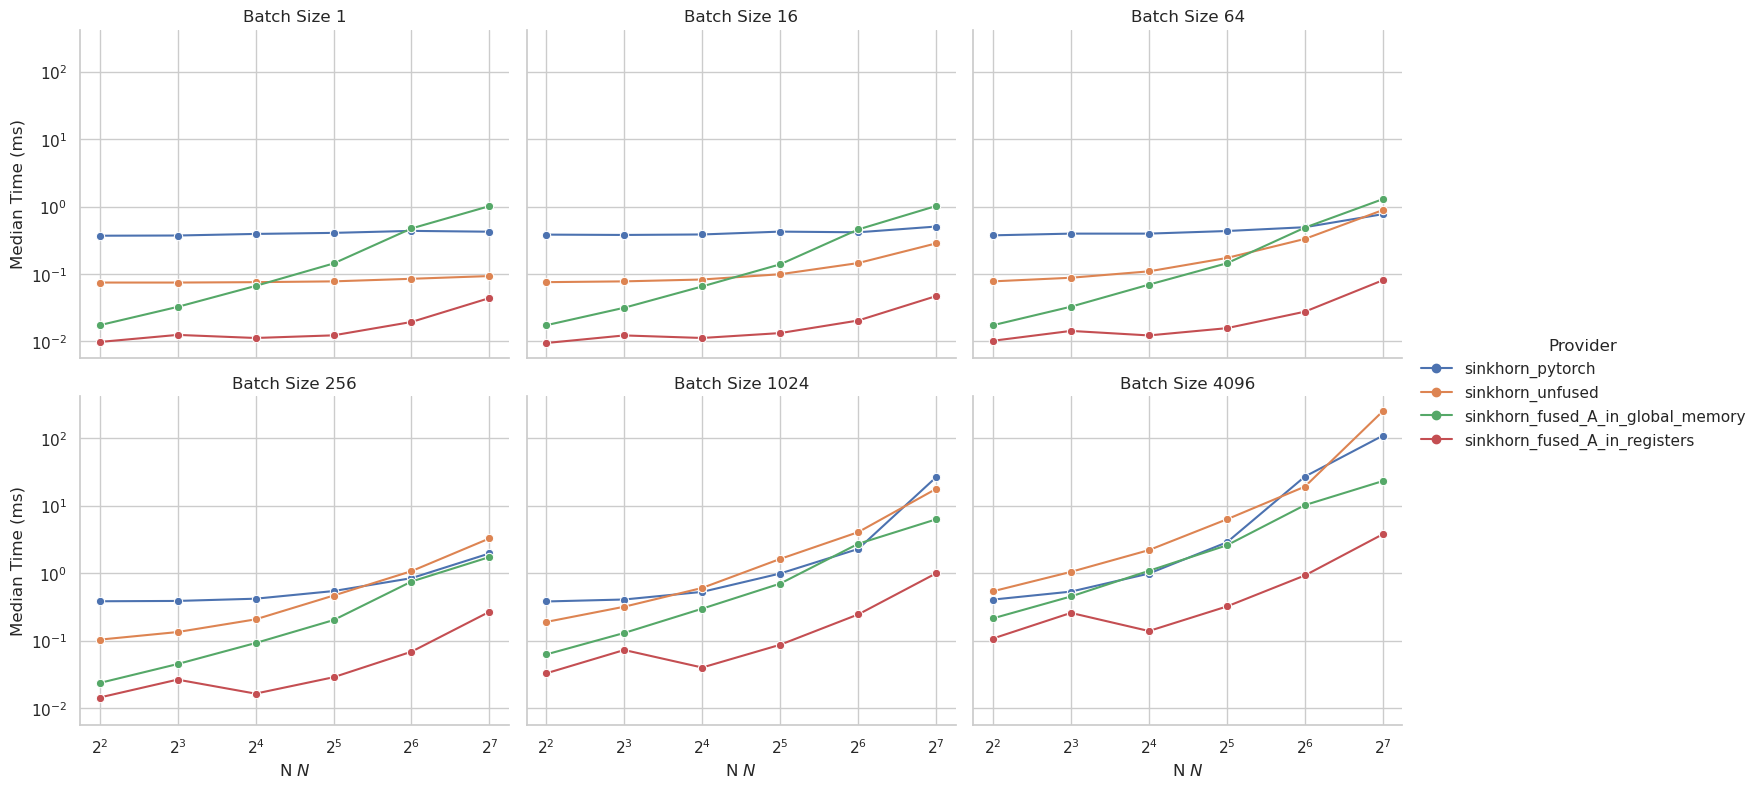

In [4]:
def plot_faceted_lines(df):
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create a FacetGrid: One plot per Batch Size
    g = sns.relplot(
        data=df,
        x="N", 
        y="Median",  # or "Median" for time
        hue="Provider",
        col="Batch Size",
        kind="line",
        marker="o",
        col_wrap=3,     # Wraps to new line after 3 plots
        height=4,
        aspect=1.2,
    )
    
    g.set_titles("Batch Size {col_name}")
    g.set_xlabels("N $N$")
    g.set_ylabels("Median Time (ms)")
    plt.xscale('log', base=2)
    plt.yscale('log', base=10)
    plt.show()


plot_faceted_lines(df)

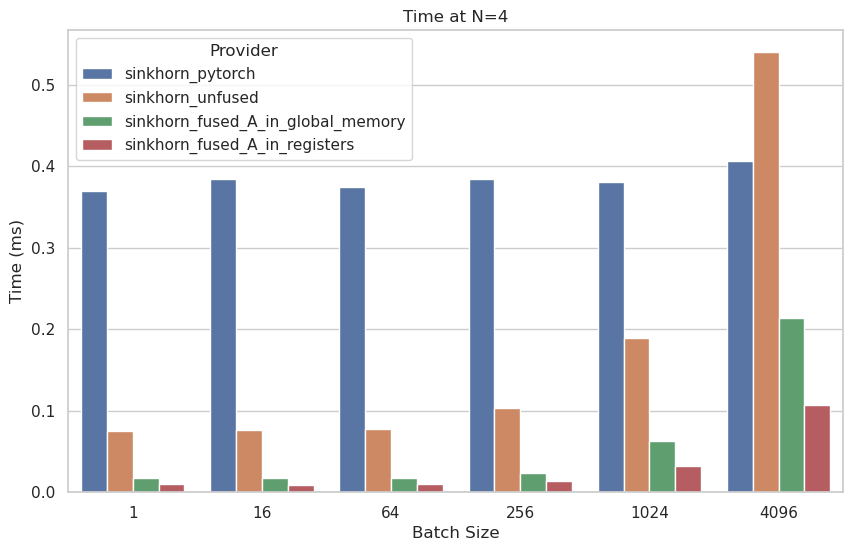

In [9]:
def plot_grouped_bars(df):
    # Filter for a specific large batch size if needed, or plot all
    subset = df[df["N"] == 4] # mHC paper
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=subset,
        x="Batch Size",
        y="Median",
        hue="Provider"
    )
    plt.title("Time at N=4")
    plt.ylabel("Time (ms)")
    plt.show()

plot_grouped_bars(df)

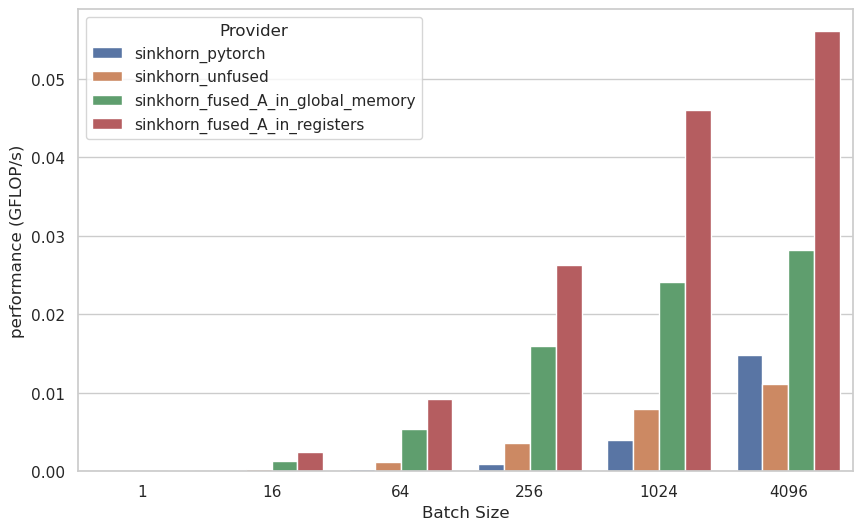

In [ ]:
subset = df[df["N"] == 4] # mHC paper
    
plt.figure(figsize=(10, 6))
sns.barplot(
    data=subset,
    x="Batch Size",
    y="performance",
    hue="Provider"
)
plt.ylabel("performance (MFLOP/s)")
plt.show()


In [ ]:
subset = df[df["N"] == 4] # mHC paper
    
plt.figure(figsize=(10, 6))
sns.barplot(
    data=subset,
    x="Batch Size",
    y="bandwidth",
    hue="Provider"
)
plt.ylabel("bandwidth (GB/s)")
plt.show()
